https://www.coursera.org/lecture/convolutional-neural-networks/anchor-boxes-yNwO0
    
https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab
    
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

https://medium.com/@jonathan_hui/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [6]:
sys.path.append("../fastai/old/")
from fastai.conv_learner import *

In [7]:
path = Path("../DATA/airbus-ship/")
files = list(path.iterdir())

In [8]:
list(path.glob("*/**"))

[PosixPath('../DATA/airbus-ship/train'),
 PosixPath('../DATA/airbus-ship/segmentation'),
 PosixPath('../DATA/airbus-ship/segmentation/train_masks'),
 PosixPath('../DATA/airbus-ship/segmentation/test_masks'),
 PosixPath('../DATA/airbus-ship/submission'),
 PosixPath('../DATA/airbus-ship/test_v2'),
 PosixPath('../DATA/airbus-ship/tmp'),
 PosixPath('../DATA/airbus-ship/detection'),
 PosixPath('../DATA/airbus-ship/test_detection'),
 PosixPath('../DATA/airbus-ship/models'),
 PosixPath('../DATA/airbus-ship/classification'),
 PosixPath('../DATA/airbus-ship/test')]

In [9]:
# original files
train_segmentations = pd.read_csv(path/"train_ship_segmentations.csv")
test_segmentations = pd.read_csv(path/"test_ship_segmentations.csv")

### Visualize detection data

In [6]:
from skimage.measure import regionprops
from eval_metric import get_gt_masks
from seg_plots import show_img_masks, plot_segmentation_df

In [7]:
# images with ships
train_seg_lbs = pd.read_csv(path/"segmentation/trn_segmentation.csv")
test_seg_lbs = pd.read_csv(path/"segmentation/test_segmentation.csv")

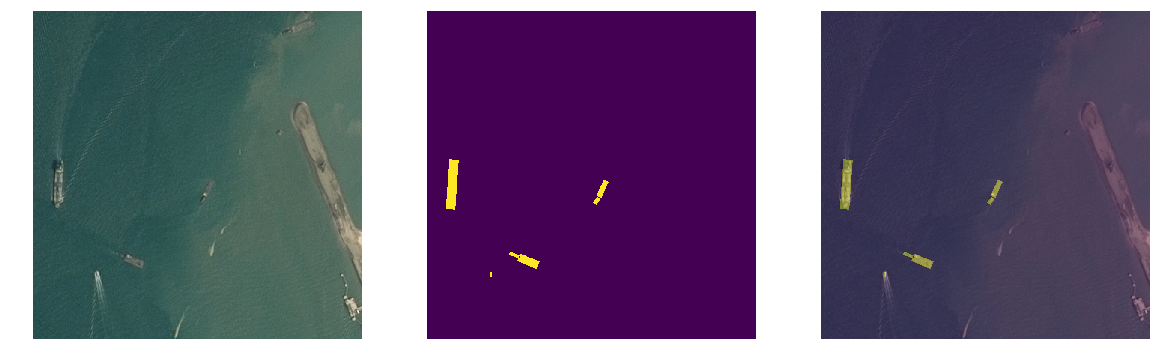

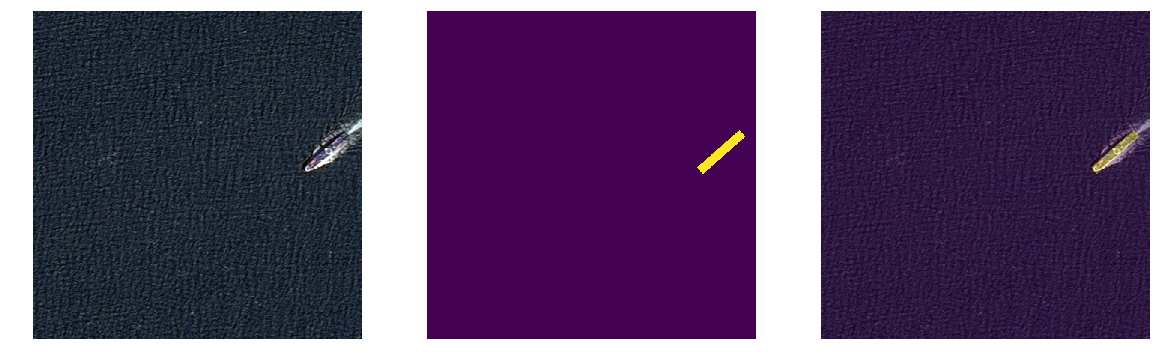

In [10]:
plot_segmentation_df(train_seg_lbs, path/"train", 3)

In [11]:
ship_id = np.random.choice(train_seg_lbs.ImageId)
gt_rles = train_seg_lbs[train_seg_lbs.ImageId == ship_id]['EncodedPixels'].values
len(gt_rles)

1

In [12]:
ship_id

'ceee918b9.jpg'

In [13]:
img = open_image(path/"train"/ship_id)

In [14]:
gt_masks = get_gt_masks(gt_rles)

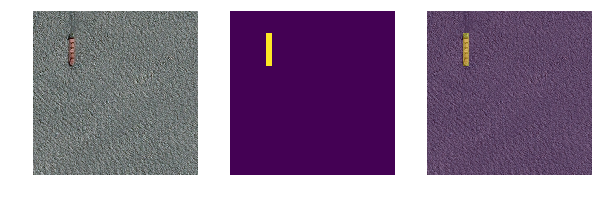

In [15]:
show_img_masks(img, sum(gt_masks))

In [16]:
props = [regionprops(gt_mask) for gt_mask in gt_masks]

In [17]:
bboxes = [prop[0]['bbox'] for prop in props]

In [18]:
bboxes

[(109, 166, 260, 197)]

In [19]:
from detect_plots import draw_bbox

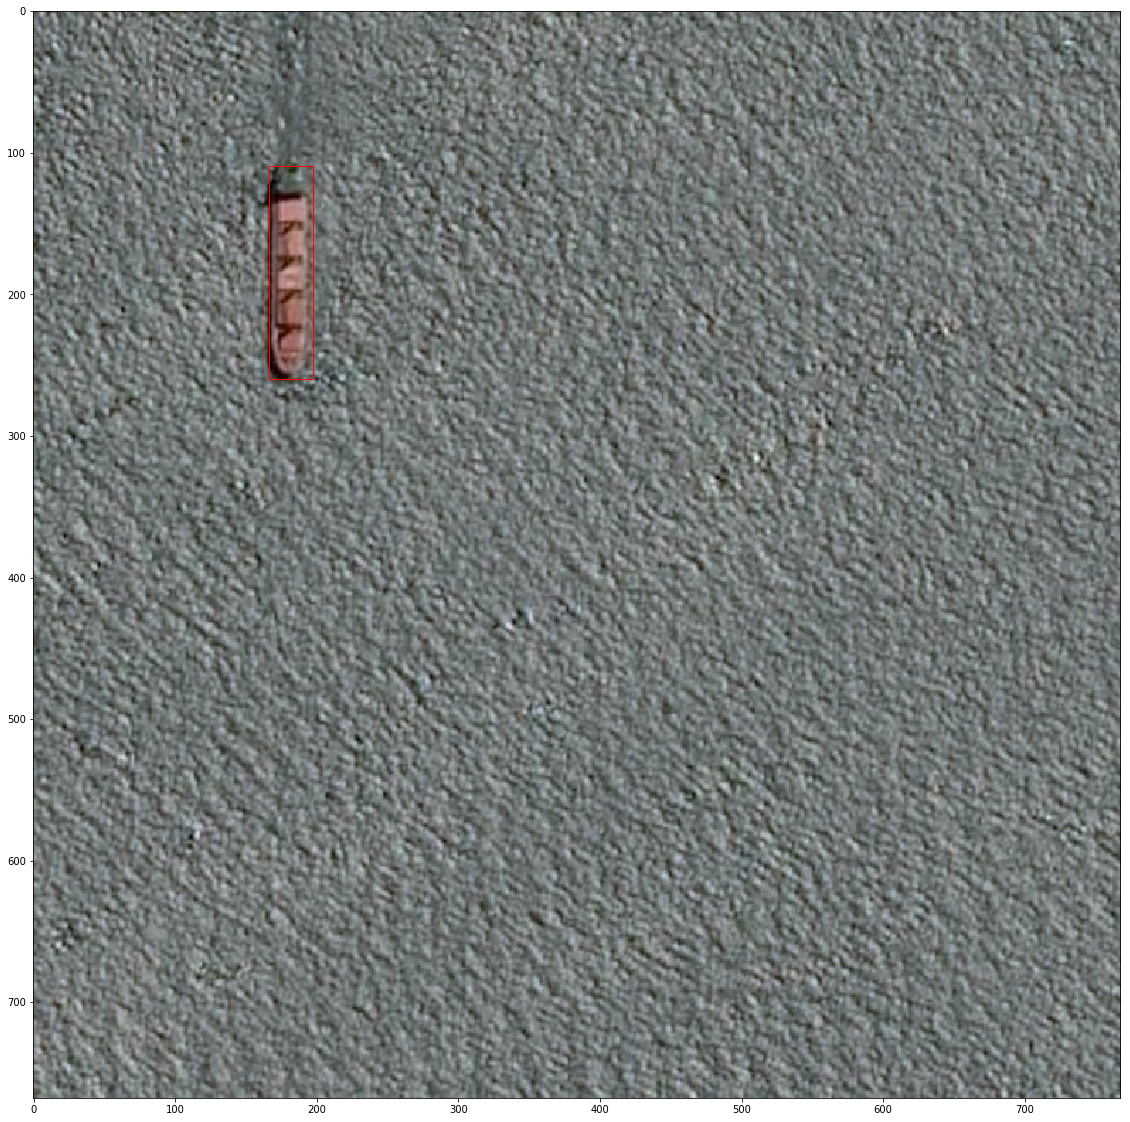

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(img)
for bbox in bboxes: draw_bbox(bbox, axes)

### Create object detection data

In [32]:
train_ship_ids = train_seg_lbs.ImageId.unique()
test_ship_ids = test_seg_lbs.ImageId.unique()

#### train

In [33]:
df = train_seg_lbs
ship_id_bbox = []

for img_id in train_ship_ids:
    try:
        gt_rles = df[df.ImageId == img_id]['EncodedPixels'].values
        gt_masks = get_gt_masks(gt_rles)
        props = [regionprops(gt_mask) for gt_mask in gt_masks]
        bboxes = [prop[0]['bbox'] for prop in props]
        n = len(ship_id_bbox)
        for bbox in bboxes: ship_id_bbox.append((img_id, bbox))
    except: pass

In [34]:
ship_ids, bboxes = list(zip(*ship_id_bbox))
train_bbox_lbs = pd.DataFrame({"ImageId": ship_ids, "BoundingBox": bboxes})

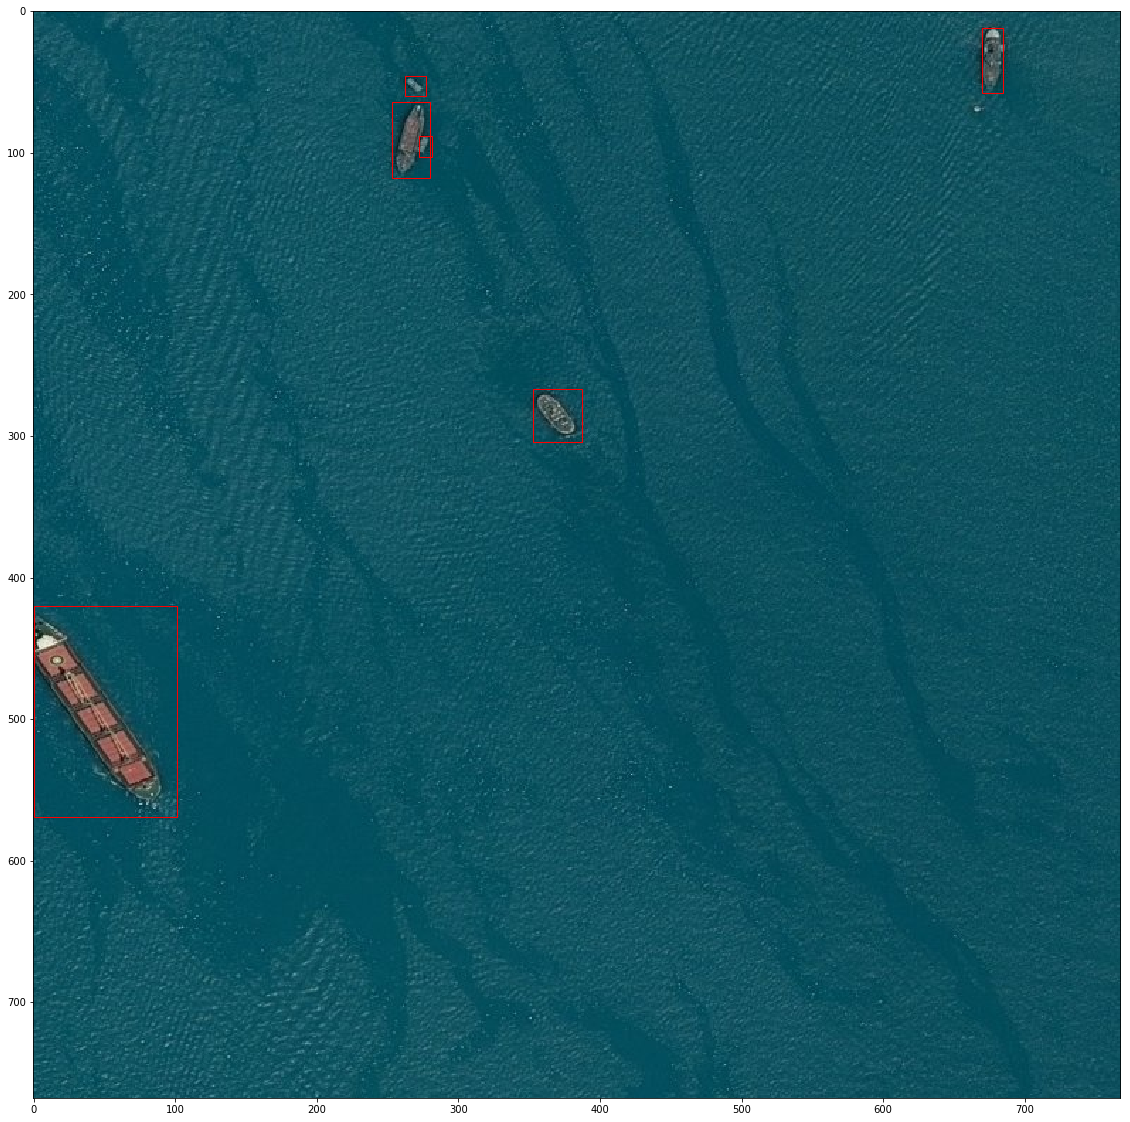

In [48]:
i = 100
img_id = train_bbox_lbs.ImageId[i]
img = open_image(path/"train"/f"{img_id}")
bboxes = train_bbox_lbs[train_bbox_lbs.ImageId == img_id]['BoundingBox'].values
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(img)
for bbox in bboxes: draw_bbox(bbox, axes)

In [63]:
train_bboxes = np.stack(train_bbox_lbs.BoundingBox.apply(lambda x: A(x)))

#### test

In [68]:
df = test_seg_lbs
ship_id_bbox = []

for img_id in test_ship_ids:
    try:
        gt_rles = df[df.ImageId == img_id]['EncodedPixels'].values
        gt_masks = get_gt_masks(gt_rles)
        props = [regionprops(gt_mask) for gt_mask in gt_masks]
        bboxes = [prop[0]['bbox'] for prop in props]
        n = len(ship_id_bbox)
        for bbox in bboxes: ship_id_bbox.append((img_id, bbox))
    except:pass

In [69]:
ship_ids, bboxes = list(zip(*ship_id_bbox))
test_bbox_lbs = pd.DataFrame({"ImageId": ship_ids, "BoundingBox": bboxes})

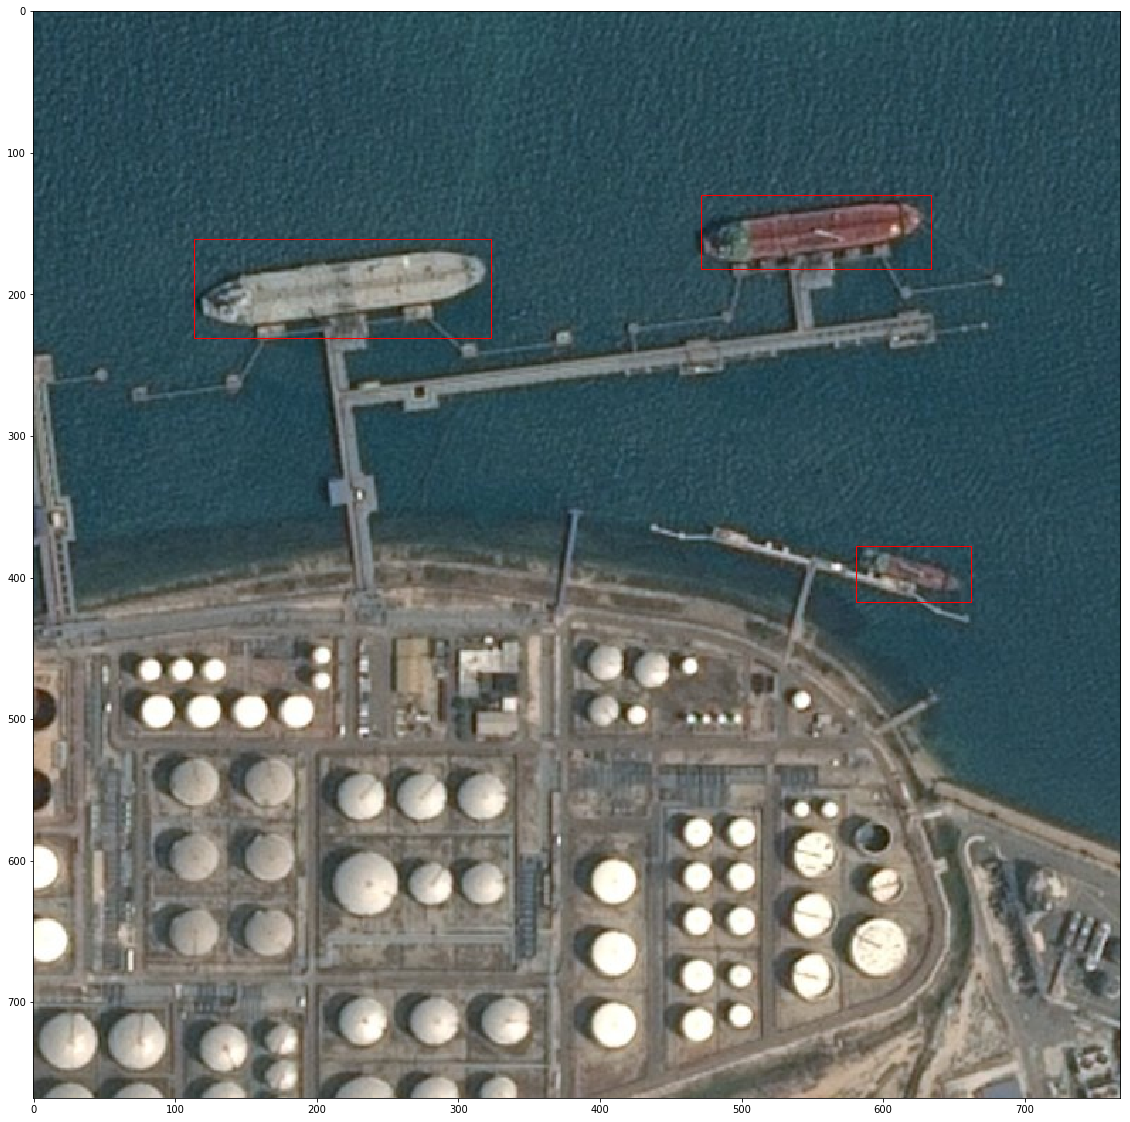

In [72]:
i = 100
img_id = test_bbox_lbs.ImageId[i]
img = open_image(path/"test"/f"{img_id}")
bboxes = test_bbox_lbs[test_bbox_lbs.ImageId == img_id]['BoundingBox'].values
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(img)
for bbox in bboxes: draw_bbox(bbox, axes)

In [73]:
test_bboxes = np.stack(train_bbox_lbs.BoundingBox.apply(lambda x: A(x)))

#### save files

In [79]:
os.makedirs(path/"detection", exist_ok=True)

train_bbox_lbs.to_csv(path/"detection/trn_detection.csv", index=False)
test_bbox_lbs.to_csv(path/"detection/test_detection.csv", index=False)

### Detection data

In [21]:
train_bbox_lbs = pd.read_csv(path/"detection/trn_detection.csv")
test_bbox_lbs = pd.read_csv(path/"detection/test_detection.csv")

In [22]:
# min row, min col, max row, max col
print(train_bbox_lbs.shape)
train_bbox_lbs.head()

(73166, 2)


ImageId           BoundingBox
0  000155de5.jpg  (465, 344, 501, 448)
1  00021ddc3.jpg  (732, 131, 762, 168)
2  00021ddc3.jpg  (755, 123, 767, 136)
3  00021ddc3.jpg   (715, 96, 720, 107)
4  00021ddc3.jpg  (661, 195, 665, 201)

In [23]:
train_bbox_lbs.BoundingBox = train_bbox_lbs.BoundingBox.apply(lambda x: x[1:-1].replace(",", ""))
test_bbox_lbs.BoundingBox = test_bbox_lbs.BoundingBox.apply(lambda x: x[1:-1].replace(",", ""))

In [24]:
train_bbox_lbs = train_bbox_lbs.groupby("ImageId").apply(lambda x: " ".join(x['BoundingBox'])).reset_index().rename(columns={0:'BoundingBox'})
test_bbox_lbs = test_bbox_lbs.groupby("ImageId").apply(lambda x: " ".join(x['BoundingBox'])).reset_index().rename(columns={0:'BoundingBox'})

In [25]:
# min row, min col, max row, max col
print(train_bbox_lbs.shape)
train_bbox_lbs.head()

(38174, 2)


ImageId                                        BoundingBox
0  000155de5.jpg                                    465 344 501 448
1  000194a2d.jpg  377 67 386 85 287 469 307 492 178 331 197 370 ...
2  00021ddc3.jpg  732 131 762 168 755 123 767 136 715 96 720 107...
3  0002756f7.jpg                        36 333 62 351 41 324 67 345
4  000532683.jpg                    460 597 474 604 756 738 763 747

In [26]:
train_bbox_lbs.to_csv(path/"detection/train_bbox_lbs2.csv", index=False)
test_bbox_lbs.to_csv(path/"detection/test_bbox_lbs2.csv", index=False)

In [27]:
train_bbox_lbs.shape, test_bbox_lbs.shape

((38174, 2), (4382, 2))

### Construct SSD data

In [28]:
train_bbox_lbs = pd.read_csv(path/"detection/train_bbox_lbs2.csv")
test_bbox_lbs = pd.read_csv(path/"detection/test_bbox_lbs2.csv")

In [29]:
train_bbox_lbs.head(2)

ImageId                                        BoundingBox
0  000155de5.jpg                                    465 344 501 448
1  000194a2d.jpg  377 67 386 85 287 469 307 492 178 331 197 370 ...

In [32]:
train_n_instance = train_bbox_lbs['BoundingBox'].apply(lambda x: len((x).split(" "))//4)
test_n_instance = test_bbox_lbs['BoundingBox'].apply(lambda x: len((x).split(" "))//4)

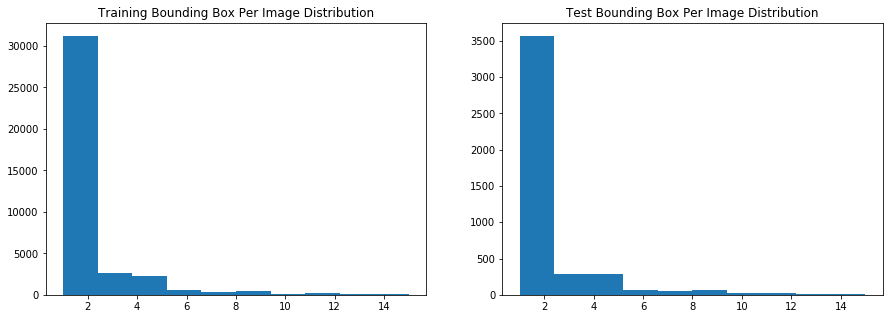

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title("Training Bounding Box Per Image Distribution")
axes[0].hist(train_n_instance)
axes[1].set_title("Test Bounding Box Per Image Distribution")
axes[1].hist(test_n_instance)
plt.show()

In [50]:
Counter(train_n_instance).most_common(10) 

[(1, 24341),
 (2, 6869),
 (3, 2671),
 (4, 1431),
 (5, 832),
 (6, 592),
 (7, 358),
 (8, 287),
 (9, 213),
 (10, 146)]

In [48]:
Counter(test_n_instance).most_common(10)

[(1, 2763),
 (2, 805),
 (3, 283),
 (4, 191),
 (5, 93),
 (6, 65),
 (7, 48),
 (8, 31),
 (9, 30),
 (10, 22)]

### Show Bboxes

Images have different levels of zoom

In [51]:
from detect_plots import draw_bbox, draw_bbox_on_img

In [82]:
i = 6
img_id, bboxes = train_bbox_lbs.iloc[i]['ImageId'], train_bbox_lbs.iloc[i]['BoundingBox']

In [83]:
bboxes = np.array(bboxes.split(" "), dtype=np.int32).reshape(-1, 4).tolist(); bboxes

[[598, 72, 739, 237], [252, 476, 321, 556]]

In [84]:
bboxes

[[598, 72, 739, 237], [252, 476, 321, 556]]

0005d01c8.jpg


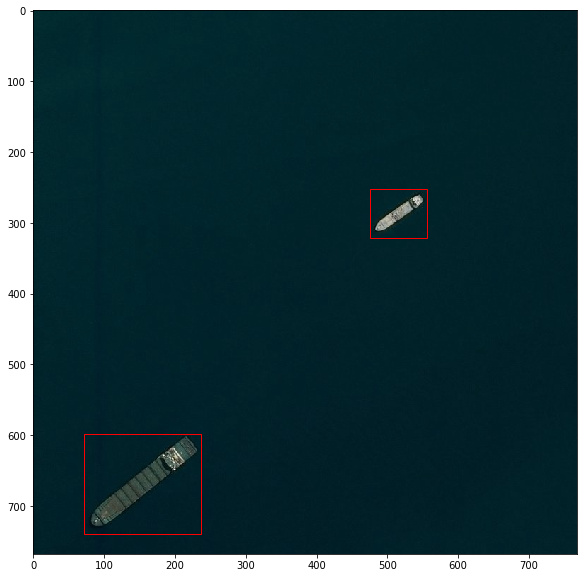

In [85]:
print(img_id)
img = open_image(path/f"train/{img_id}")
draw_bbox_on_img(img, bboxes)

### Find single images

In [87]:
single_object_mask = train_bbox_lbs['BoundingBox'].apply(lambda x: len(x.split(" "))//4) == 1
train_bbox_lbs_single = train_bbox_lbs[single_object_mask].reset_index(drop=True)

In [88]:
bboxes_single = np.stack(train_bbox_lbs_single.BoundingBox.apply(lambda x: x.split())).astype(int)

In [89]:
train_bbox_lbs_single.to_csv(path/"detection/train_bbox_lbs2_single.csv", index=False)

In [90]:
# create classifcation dataframe
train_cls_lbs_single = train_bbox_lbs_single.drop("BoundingBox", 1)
train_cls_lbs_single['Classes'] = 0 # idxs -> n_cls + background_cls

In [91]:
train_cls_lbs_single.head()

ImageId  Classes
0  000155de5.jpg        0
1  00053c6ba.jpg        0
2  0005d6d95.jpg        0
3  0006c52e8.jpg        0
4  000d42241.jpg        0

In [92]:
mcls = [np.array([cls]) for cls in train_cls_lbs_single.Classes.values]

In [93]:
mcls[:3]

[array([0]), array([0]), array([0])]

### Dataset

In [10]:
f_model=resnet34
sz= 768

In [25]:
aug_tfms=[RandomDihedral(tfm_y=TfmType.COORD),
          RandomBlur(tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)]

In [26]:
# copy test detection images to test_detection
# os.makedirs(path/"test_detection", exist_ok=True)
# for fname in test_fnames: shutil.copyfile(path/f"test/{fname}", path/f"test_detection/{fname}")

In [27]:
tfms = tfms_from_model(f_model, sz,
                       crop_type=CropType.NO,
                       tfm_y=TfmType.COORD,
                       aug_tfms=aug_tfms)

md = ImageClassifierData.from_csv(path,
                                  "train",
                                  path/"detection/train_bbox_lbs2.csv",
                                  tfms=tfms, continuous=True, bs=16, test_name="test_detection")

denorm = md.trn_ds.denorm

In [28]:
len(md.trn_ds), len(md.val_ds), len(md.test_ds)

(30540, 7634, 4382)

In [29]:
train_bbox_lbs = pd.read_csv(path/"detection/train_bbox_lbs2.csv")

In [30]:
trn_fnames = [fname.split("/")[1] for fname in md.trn_ds.fnames]
val_fnames = [fname.split("/")[1] for fname in md.val_ds.fnames]

In [31]:
train_bbox_lbs.head()

ImageId                                        BoundingBox
0  000155de5.jpg                                    465 344 501 448
1  000194a2d.jpg  377 67 386 85 287 469 307 492 178 331 197 370 ...
2  00021ddc3.jpg  732 131 762 168 755 123 767 136 715 96 720 107...
3  0002756f7.jpg                        36 333 62 351 41 324 67 345
4  000532683.jpg                    460 597 474 604 756 738 763 747

In [32]:
trn_bbox = pd.merge(pd.DataFrame({"ImageId": trn_fnames}), train_bbox_lbs, on='ImageId')['BoundingBox']
val_bbox = pd.merge(pd.DataFrame({"ImageId": val_fnames}), train_bbox_lbs, on='ImageId')['BoundingBox']

In [33]:
len(trn_bbox), len(val_bbox)

(30540, 7634)

In [34]:
trn_mcls = list(trn_bbox.apply(lambda x: np.array([0]*(len(x.split(" "))//4))))
val_mcls = list(val_bbox.apply(lambda x: np.array([0]*(len(x.split(" "))//4))))

In [35]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, mcls):
        self.ds = ds
        self.sz = ds.sz
        self.mcls = mcls
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        y2 = self.mcls[i]
        return (x, (y, y2))

In [36]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcls)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcls)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [37]:
from detect_plots import draw_bbox_on_img

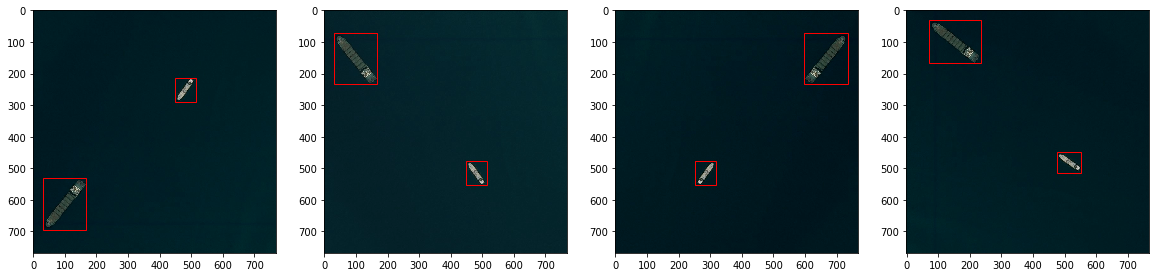

In [24]:
i = 1
fig_sz = (20, 20)
fig, axes = plt.subplots(1, 4, figsize=fig_sz)
for ax in axes.flatten():
    x,y = next(iter(md.aug_dl))
    img = denorm(x)[i]
    bboxes = to_np(y[i]).reshape(-1,4)
    bboxes = bboxes[np.sum(bboxes,1) != 0].tolist()
    draw_bbox_on_img(img, bboxes, ax=ax)

### Anchor boxes

In [38]:
from anchor_box import plot_anchors, hw2corners, get_anchor_boxes
from detect_plots import draw_bbox

In [39]:
anc_grids = [12]
anc_zooms = [0.5, 1., 2]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]

In [40]:
anchors, grid_sizes, anchor_cnr, scales, anc_sizes = get_anchor_boxes(anc_grids, anc_zooms, anc_ratios)

In [41]:
anchors

Variable containing:
 0.0417  0.0417  0.0417  0.0417
 0.0417  0.0417  0.0417  0.0208
 0.0417  0.0417  0.0208  0.0417
               ⋮                
 0.9583  0.9583  0.1667  0.1667
 0.9583  0.9583  0.1667  0.0833
 0.9583  0.9583  0.0833  0.1667
[torch.cuda.FloatTensor of size 1296x4 (GPU 0)]

In [42]:
grid_sizes

Variable containing:
1.00000e-02 *
 8.3333
 8.3333
 8.3333
   ⋮    
 8.3333
 8.3333
 8.3333
[torch.cuda.FloatTensor of size 1296x1 (GPU 0)]

In [43]:
anchor_cnr

Variable containing:
 0.0208  0.0208  0.0625  0.0625
 0.0208  0.0312  0.0625  0.0521
 0.0312  0.0208  0.0521  0.0625
               ⋮                
 0.8750  0.8750  1.0417  1.0417
 0.8750  0.9167  1.0417  1.0000
 0.9167  0.8750  1.0000  1.0417
[torch.cuda.FloatTensor of size 1296x4 (GPU 0)]

In [44]:
anc_sizes

Variable containing:
 0.0417  0.0417
 0.0417  0.0208
 0.0208  0.0417
       ⋮        
 0.1667  0.1667
 0.1667  0.0833
 0.0833  0.1667
[torch.cuda.FloatTensor of size 1296x2 (GPU 0)]

In [45]:
scales

[(0.5, 0.5),
 (0.5, 0.25),
 (0.25, 0.5),
 (1.0, 1.0),
 (1.0, 0.5),
 (0.5, 1.0),
 (2.0, 2.0),
 (2.0, 1.0),
 (1.0, 2.0)]

In [46]:
k = len(scales);k

9

In [47]:
anchor_cnr_np = to_np(anchor_cnr)

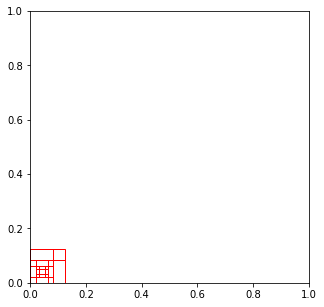

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for bbox in anchor_cnr_np[:9]: draw_bbox(bbox, ax)

### Model

model should be modified to multi head if different # of anchor grid will be used

(x - K + 2P / S) + 1

In [49]:
# number of classes excluding background
n_cls = 1

In [50]:
class StdConv(nn.Module):
    """conv - relu - batchnorm - dropout"""
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [51]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias, n_cls=1):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (n_cls+1)*k, 3, padding=1) 
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1) 
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [52]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        """
        SSD adds 6 more auxiliary convolution layers after the VGG16. 
        Five of them will be added for object detection.
        In three of those layers, we make 6 predictions instead of 4.
        In total, SSD makes 8732 predictions using 6 layers.
        
        """
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)

In [53]:
head_reg4 = SSD_Head(k, -3.)
f_model=resnet34
sz=sz
models = ConvnetBuilder(f_model, c=0, is_multi=0, is_reg=0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [54]:
*x,y = next(iter(md.trn_dl))

In [55]:
out_cls, out_bbox = learn.model(V(*x))

In [56]:
out_cls.shape, out_bbox.shape

(torch.Size([16, 1296, 2]), torch.Size([16, 1296, 4]))

In [57]:
anchor_cnr.shape

torch.Size([1296, 4])

In [58]:
assert out_bbox.shape[1] == anchor_cnr.shape[0]

In [59]:
y[0].shape, y[1].shape

(torch.Size([16, 16]), torch.Size([16, 4]))

### Check receptive field match with anchor orders

with multihead we can flatten the out with the same method and then concatenate grid1, grid2, ..., gridn

Receptive Field Moves from left to right

x1, y1, k1 

...

x2, y1, k1 

as opposed anchors

In [184]:
dummy_out = torch.from_numpy(np.arange(18*12*12).reshape(1, 18, 12, 12))

In [185]:
dummy_out.shape

torch.Size([1, 18, 12, 12])

In [186]:
dummy_reshaped = dummy_out.permute(0,2,3,1).contiguous().view(1,-1,18//k)

In [ ]:
# preds for loc x1, y1 after reshape
dummy_reshaped[:, :9]

In [ ]:
# preds for loc x2, y1 after reshape
dummy_reshaped[: 9:18]

In [ ]:
# preds for loc x3, y1
dummy_out[:, :, 0, 0]

In [ ]:
# preds for loc x4, y2
dummy_out[:, :, 0, 1]

### Train

We begin by matching each ground truth box to the default box with the best
jaccard overlap (as in MultiBox [7]). Unlike MultiBox, we then match default boxes to
any ground truth with jaccard overlap higher than a threshold (0.5). This simplifies the
learning problem, allowing the network to predict high scores for multiple overlapping
default boxes rather than requiring it to pick only the one with maximum overlap.

In [60]:
from detect_utils import get_y, actn_to_bb
from detect_utils import jaccard
from detect_utils import map_to_ground_truth
from detect_utils import ssd_1_loss

In [61]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()].cuda()

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self,x,t): return None

cls_loss = BCE_Loss(num_classes=n_cls)

In [62]:
def ssd_loss(pred, targ, alpha=1, print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, sz, anchors,
                                        anchor_cnr, anc_sizes, cls_loss,
                                        n_cls=1, print_it=False)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls*alpha+lcs

In [63]:
from detect_plots import draw_bbox, draw_text, plot_detect_pred
from detect_utils import nms
from eval_metric import create_iou_matrix, f2_IOU

In [64]:
def bbox_to_mask_arrays(bboxes, sz=(768, 768)):
    mask_arrays = []
    for bbox in bboxes:
        mask_array = np.zeros(sz)
        min_y, min_x, max_y, max_x = bbox
        mask_array[min_y:max_y, min_x:max_x] = 1
        mask_arrays.append(mask_array)
    return mask_arrays

In [65]:
def single_image_score2(pred_mask_arrays, gt_mask_arrays):
    """return avg thresholded f2 score for single image"""
    if pred_mask_arrays == []:
        if gt_mask_arrays is None: 
            return 1
        else: return 0 
    else:
        IOU = create_iou_matrix(pred_mask_arrays, gt_mask_arrays)
        return f2_IOU(IOU)

In [66]:
def detect_metric(pred, targ, do_nms=True, thresh=0.5, print_it=False):
    scores = 0
    bs = pred[0].shape[0]
    for pred_clas, pred_bbox, gt_bbox, gt_clas in zip(*pred,*targ):
        # get gt
        gt_bbox, gt_clas = get_y(gt_bbox, gt_clas, sz)
        # activation to bbox corner
        a_ic = actn_to_bb(pred_bbox, anchors.data, anc_sizes.data)
        # get probabilities for class
        cls_idx = 0
        pred_proba = to_np(F.softmax(V(pred_clas)))[:, cls_idx]
        # get thresholded predictions
        pred_bbox_mask = pred_proba > thresh
        pred_bbox_probas = np.round(pred_proba[pred_bbox_mask], 2)
        pred_bbox_corner = to_np(a_ic*sz).astype(int)[pred_bbox_mask]
        # nms
        if do_nms:
            # remaining boxes
            post_nms_idxs = []
            # non max supression
            sorted_idx = np.argsort(pred_bbox_probas)[::-1]
            post_nms_idxs = nms(sorted_idx, pred_bbox_corner)
            pred_bbox_corner = pred_bbox_corner[post_nms_idxs]
            pred_bbox_probas = pred_bbox_probas[post_nms_idxs]
        
        # get gt and pred mask arrays 
        pred_mask_arrays = bbox_to_mask_arrays(pred_bbox_corner)
        gt_mask_arrays = bbox_to_mask_arrays((to_np(gt_bbox)*sz).astype(int))
        
        # get score for single image
        score = single_image_score2(pred_mask_arrays, gt_mask_arrays)
        scores += score
    return scores/bs

In [67]:
learn.metrics = [detect_metric]

In [68]:
learn.crit = ssd_loss

In [48]:
learn.lr_find()

 66%|██████▌   | 1261/1909 [08:17<02:38,  4.08it/s, loss=337]    

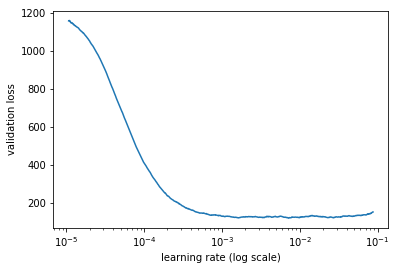

In [49]:
learn.sched.plot()

In [69]:
learn.data.sz

768

In [73]:
x[0].shape

torch.Size([16, 3, 768, 768])

In [74]:
lr = 5e-3
learn.fit(lr, n_cycle=2, cycle_len=10, use_clr=(20, 10))

  1%|          | 16/1909 [00:52<1:28:21,  2.80s/it, loss=971]     

IndexError: trying to index 2 dimensions of a 0 dimensional tensor

In [ ]:
learn.save("resnet34_detection.768")

### Visualize Preds

In [55]:
from detect_plots import plot_detect_pred

In [54]:
learn.load("resnet34_detection.256")
model = learn.model.eval()
denorm = learn.data.val_ds.ds.denorm

In [65]:
*x,y = next(iter(learn.data.val_dl))

In [66]:
# actual and predicted
out = model(*V(x))
bbox, clas = y
pred_clas, pred_bbox = out

In [150]:
def plot_detect_pred(img, pred_clas, pred_bbox, clas, bbox, anchors,
                     anc_sizes, sz, cls_idx=0, thresh=0.5, do_nms=True, figsize=(20,20), zoom=False):
    # activation to bbox corner
    a_ic = actn_to_bb(pred_bbox, anchors, anc_sizes)
    # copy bbox
    actual_bb = to_np(bbox).copy()
    # get probabilities
    pred_proba = to_np(F.softmax(pred_clas))[:, cls_idx]
    # get thresholded predictions
    pred_bbox_mask = pred_proba > thresh
    pred_bbox_probas = np.round(pred_proba[pred_bbox_mask], 2)
    pred_bbox_corner = to_np(a_ic*sz).astype(int)[pred_bbox_mask]
    # do non max suppresion
    if do_nms:
        # remaining boxes
        post_nms_idxs = []
        # non max supression
        sorted_idx = np.argsort(pred_bbox_probas)[::-1]
        post_nms_idxs = nms(sorted_idx, pred_bbox_corner)
        pred_bbox_corner = pred_bbox_corner[post_nms_idxs]
        pred_bbox_probas = pred_bbox_probas[post_nms_idxs]
    # actual bbox
    actual_bbox = actual_bb*sz
    # plot
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    for i, (bbox, proba) in enumerate(zip(pred_bbox_corner, pred_bbox_probas)): 
        draw_bbox(bbox, axes)
        draw_text(axes, bbox[:2][::-1], f"pred_{i}")
        draw_text(axes, bbox[:2][::-1], f"proba:{proba}")

    for i, bbox in enumerate(actual_bbox):
        draw_bbox(bbox, axes, "white")
        draw_text(axes, bbox[:2][::-1], f"gt_{i}")
    axes.imshow(img)
    
    if zoom:
        axes.set_ylim(top=500)
        axes.set_xlim(right=500)
    

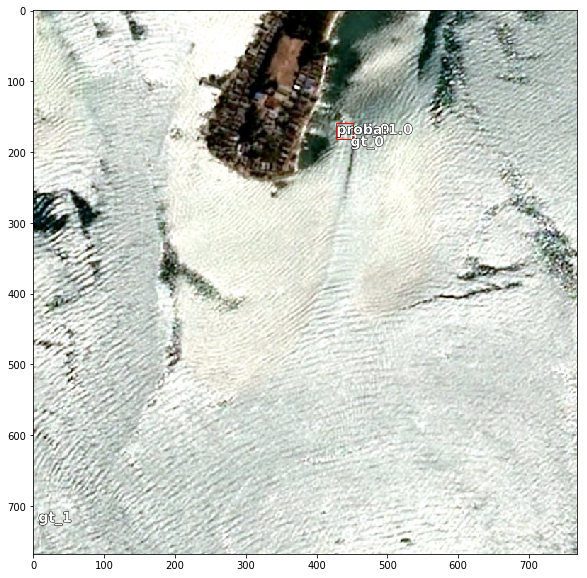

In [152]:
i = 6

img = denorm(x[0][i])[0]

pred_clasi = pred_clas[i]
pred_bboxi = pred_bbox[i]

actual_clasi = clas[i]
actual_bboxi = bbox[i]

actual_bboxi, actual_clasi = get_y(actual_bboxi, actual_clasi, sz)
actual_bboxi, actual_clasi = to_np(actual_bboxi), to_np(actual_clasi)

axes = plot_detect_pred(img=img, pred_clas=pred_clasi,
                 pred_bbox=pred_bboxi,clas=None,
                 bbox=actual_bboxi,anchors=anchors,
                 anc_sizes=anc_sizes, sz=sz, figsize=(10, 10), zoom=False)